<a href="https://colab.research.google.com/github/Htets-Corner/CIFAKE/blob/main/CIFAKE_CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Dataset download
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

100%|██████████| 105M/105M [00:01<00:00, 88.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [2]:
import os

print("Dataset is stored at:", path)
print("Files:", os.listdir(path))


Dataset is stored at: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3
Files: ['test', 'train']


In [ ]:
#Load Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.ImageFolder(root=os.path.join(path, "train"), transform=transform)
test_data = datasets.ImageFolder(root=os.path.join(path, "test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print("Train size:", len(train_data))
print("Test size:", len(test_data))
print("Classes:", train_data.classes)

Train size: 100000
Test size: 20000
Classes: ['FAKE', 'REAL']


In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: 3x32x32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 4x4
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128*4*4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)  # 2 classes: FAKE / REAL
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize model, loss, optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 20

# For tracking metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    # ---------------- TRAIN ----------------
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---------------- EVALUATE ----------------
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Using device: cpu
Epoch [1/20] Train Loss: 0.2639, Train Acc: 88.92% Test Loss: 0.1840, Test Acc: 92.91%
Epoch [2/20] Train Loss: 0.1712, Train Acc: 93.45% Test Loss: 0.1761, Test Acc: 93.25%
Epoch [3/20] Train Loss: 0.1455, Train Acc: 94.47% Test Loss: 0.1410, Test Acc: 94.53%
Epoch [4/20] Train Loss: 0.1246, Train Acc: 95.24% Test Loss: 0.1343, Test Acc: 94.79%
Epoch [5/20] Train Loss: 0.1094, Train Acc: 95.88% Test Loss: 0.1249, Test Acc: 95.24%
Epoch [6/20] Train Loss: 0.0961, Train Acc: 96.37% Test Loss: 0.1624, Test Acc: 94.09%
Epoch [7/20] Train Loss: 0.0851, Train Acc: 96.78% Test Loss: 0.1259, Test Acc: 95.46%
Epoch [8/20] Train Loss: 0.0736, Train Acc: 97.20% Test Loss: 0.1499, Test Acc: 95.05%
Epoch [9/20] Train Loss: 0.0664, Train Acc: 97.45% Test Loss: 0.1609, Test Acc: 95.11%
Epoch [10/20] Train Loss: 0.0593, Train Acc: 97.71% Test Loss: 0.1442, Test Acc: 95.33%
Epoch [11/20] Train Loss: 0.0528, Train Acc: 98.00% Test Loss: 0.1511, Test Acc: 95.53%
Epoch [12/20] Train Los

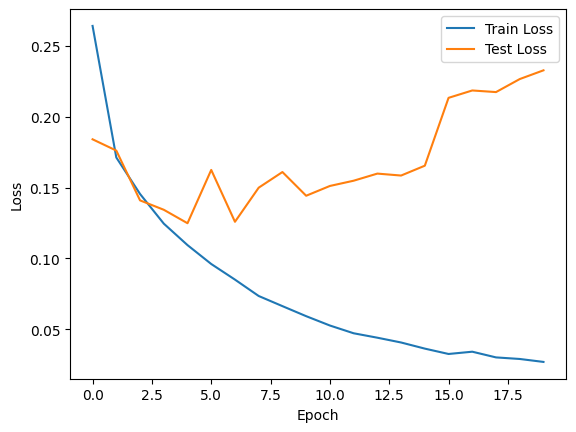

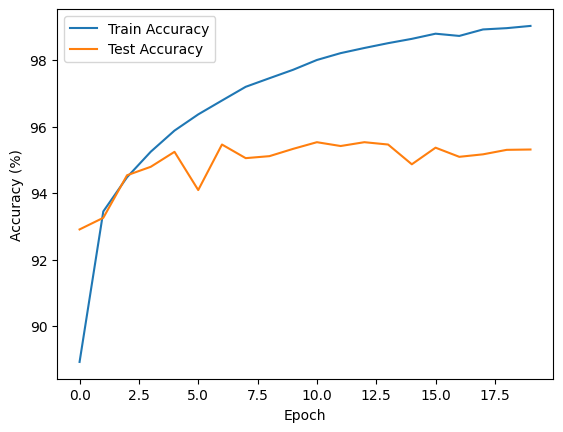

In [ ]:
import matplotlib.pyplot as plt

# Loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curves
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [ ]:
#CIFAKE CNN with:

#Data Augmentation (for better generalization)

#Early Stopping (to avoid overfitting)

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

# Data transforms with augmentation
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
train_data = datasets.ImageFolder(root=os.path.join(path, "train"), transform=transform_train)
test_data = datasets.ImageFolder(root=os.path.join(path, "test"), transform=transform_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print("Train size:", len(train_data))
print("Test size:", len(test_data))
print("Classes:", train_data.classes)


Train size: 100000
Test size: 20000
Classes: ['FAKE', 'REAL']


In [4]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128*4*4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),   # dropout for regularization
            nn.Linear(128, 2)  # 2 classes: FAKE / REAL
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [5]:
import torch
import torch.optim as optim
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
patience = 5
best_loss = float("inf")
patience_counter = 0

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    # TRAIN
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # EVALUATE
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # EARLY STOPPING
    if test_loss < best_loss:
        best_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_cnn.pth")
        print("💾 Best model saved")
    else:
        patience_counter += 1
        print(f"EarlyStopping counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹ Early stopping triggered")
            break


Using device: cpu
Epoch [1/50] Train Loss: 0.2984, Train Acc: 87.19% Test Loss: 0.2599, Test Acc: 89.14%
💾 Best model saved
Epoch [2/50] Train Loss: 0.2026, Train Acc: 92.08% Test Loss: 0.1697, Test Acc: 93.34%
💾 Best model saved
Epoch [3/50] Train Loss: 0.1824, Train Acc: 92.94% Test Loss: 0.1545, Test Acc: 94.04%
💾 Best model saved
Epoch [4/50] Train Loss: 0.1663, Train Acc: 93.61% Test Loss: 0.1594, Test Acc: 93.92%
EarlyStopping counter: 1/5
Epoch [5/50] Train Loss: 0.1544, Train Acc: 94.02% Test Loss: 0.1384, Test Acc: 94.77%
💾 Best model saved
Epoch [6/50] Train Loss: 0.1456, Train Acc: 94.49% Test Loss: 0.1346, Test Acc: 94.92%
💾 Best model saved
Epoch [7/50] Train Loss: 0.1359, Train Acc: 94.86% Test Loss: 0.1375, Test Acc: 94.82%
EarlyStopping counter: 1/5
Epoch [8/50] Train Loss: 0.1318, Train Acc: 95.07% Test Loss: 0.1260, Test Acc: 95.22%
💾 Best model saved
Epoch [9/50] Train Loss: 0.1253, Train Acc: 95.27% Test Loss: 0.1272, Test Acc: 95.11%
EarlyStopping counter: 1/5
Epoc

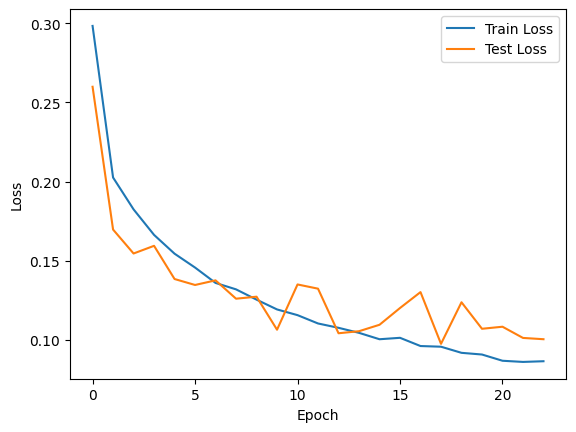

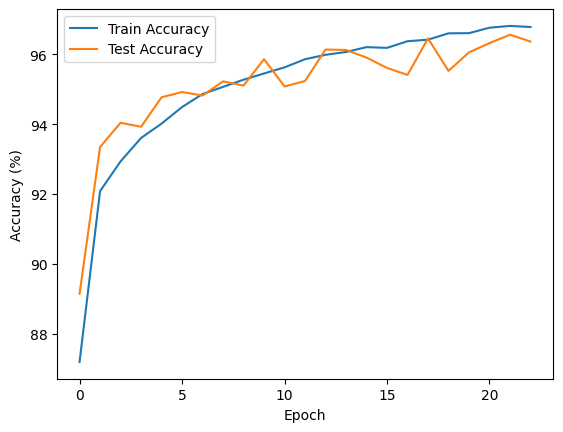

In [6]:
import matplotlib.pyplot as plt

# Loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curves
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
